# Visual Behavior Data Project Cache
A short introduction to analyzing the Visual Behavior data.
This notebook uses the LIMS API to access data, so it will only work on the Allen Institute network.

Please note that local caching functionality has not been implemented, as there are currently no NWB files for these data. Currently the `BehaviorProjectCache` acts as an interface to query for all experiments/sessions in the LIMS database, and to produce `BehaviorSession` and/or `BehaviorOphysSession` objects (using `get_session_data` and `get_behavior_session_data`, respectively).

In [1]:
import os.path
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import BehaviorProjectCache
from allensdk.brain_observatory.behavior.image_api import ImageApi

The `BehaviorProjectCache` is the main entry point to the Visual Behavior project dataset. It allows you to view cross-session summary information and create classes to analyze individual sessions. It supports both behavior-only sessions as well as sessions with behavior and optical physiology recordings.

In [2]:
# this path determines where the downloaded data will be stored

manifest_path = os.path.join("example_behavior_project_cache", "manifest.json")

cache = BehaviorProjectCache.from_lims(manifest=manifest_path)

We can view all session records present in the LIMS database.

In [3]:
ophys_sessions = cache.get_session_table()
ophys_sessions.head()
ophys_sessions.project_code.unique()

array(['VisualBehaviorIntegrationTest', 'VisBIntTestDatacube',
       'VisualBehavior', 'MesoscopeDevelopment',
       'VisualBehaviorDevelopment', 'VisualBehaviorMultiscope',
       'VisBehViralDev', 'VisualBehaviorTask1B', 'VisBehNeuroModAx',
       'DevelopmentMultiscope4areasx2d',
       'VisualBehaviorMultiscope4areasx2d'], dtype=object)

If we want to get more specific, we can look at all experiment records in the LIMS database. We can then filter down to what we're interested in.

In [4]:
ophys_experiments = cache.get_experiment_table()
ophys_experiments.head()

,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,
953659749,952430817,952554548,1018028354,VisualBehaviorMultiscope,holding,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,858992726,850862430,F,209.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],150,VISl,NaN
953659752,952430817,952554548,1018028357,VisualBehaviorMultiscope,holding,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,858992726,850862430,F,209.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],225,VISl,NaN
953659754,952430817,952554548,1018028351,VisualBehaviorMultiscope,holding,failed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,858992726,850862430,F,209.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],75,VISl,NaN
953659756,952430817,952554548,1018028360,VisualBehaviorMultiscope,holding,failed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,858992726,850862430,F,209.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],300,VISl,NaN
953659743,952430817,952554548,1018028345,VisualBehaviorMultiscope,holding,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,858992726,850862430,F,209.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],225,VISp,NaN


Let's analyze the most recent passed experiment for the Visual Behavior project.

Note that the session data will not be downloaded to your local machine.

In [5]:
latest = ophys_experiments.query("project_code == 'VisualBehavior'"
                        "& experiment_workflow_state == 'passed'")\
    .sort_values("date_of_acquisition", ascending=False).iloc[0]

print(f"Latest experiment id: {latest.name}. Acquired on {latest['date_of_acquisition']}. "
      f"Session: {latest['session_type']}")
    
session = cache.get_session_data(latest.name)

Latest experiment id: 1009468153. Acquired on 2020-02-21 16:51:35.000000. Session: OPHYS_7_receptive_field_mapping


We can look at metadata about the session:

In [6]:
session.metadata

/home/kat/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


{'rig_name': 'CAM2P.3',
 'sex': 'M',
 'age': 'P174',
 'excitation_lambda': 910.0,
 'emission_lambda': 520.0,
 'indicator': 'GCAMP6f',
 'field_of_view_width': 452,
 'field_of_view_height': 512,
 'ophys_experiment_id': 1009468153,
 'experiment_container_id': 1006071814,
 'ophys_frame_rate': 31.0,
 'stimulus_frame_rate': 60.0,
 'targeted_structure': 'VISp',
 'imaging_depth': 275,
 'session_type': 'OPHYS_7_receptive_field_mapping',
 'experiment_datetime': Timestamp('2020-02-21 16:51:35+0000', tz='UTC'),
 'reporter_line': ['Ai148(TIT2L-GC6f-ICL-tTA2)'],
 'driver_line': ['Sst-IRES-Cre'],
 'LabTracks_ID': 495789,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
 'behavior_session_uuid': UUID('f5dcecd6-864d-4a6b-82d3-43f2804d40c8')}

We can examine 2d images of cells:

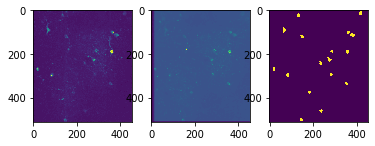

In [7]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(session.max_projection)
ax[1].imshow(session.average_projection)
ax[2].imshow(session.segmentation_mask_image)
plt.show()

We can also look at data for behavior-only sessions. These data do not have optical physiology recordings associated with them.

In [8]:
# get all behavior sessions
behavior_sessions = cache.get_behavior_session_table()
behavior_sessions.head()

,ophys_session_id,behavior_training_id,equipment_name,date_of_acquisition,donor_id,full_genotype,reporter_line,driver_line,sex,age_in_days,foraging_id,session_type
behavior_session_id,,,,,,,,,,,,
1025577299,NaN,NaN,BEH.G,2020-05-22 10:59:31.582,1009380968,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",F,144.0,745c1381-edf0-4b79-9a1e-d3673391625f,TRAINING_0_gratings_autorewards_15min
1026191301,NaN,NaN,BEH.G,2020-05-26 08:58:13.163,1009380968,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",F,148.0,fa22fd0f-da65-46cf-9f62-5aff6e4e279c,TRAINING_1_gratings
1025578252,NaN,NaN,BEH.G,2020-05-22 11:01:50.612,1009970291,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,[Ai32(RCL-ChR2(H134R)_EYFP)],[Sst-IRES-Cre],M,139.0,628c5e63-4666-4d15-a925-d4c294eafc18,TRAINING_0_gratings_autorewards_15min_0uL_reward
1025578250,NaN,NaN,BEH.G,2020-05-22 11:04:28.358,1009971263,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,[Ai32(RCL-ChR2(H134R)_EYFP)],[Vip-IRES-Cre],M,136.0,c904dc6e-8b00-4ae5-9224-95fb99255b89,TRAINING_0_gratings_autorewards_15min_0uL_reward
1026191305,NaN,NaN,BEH.G,2020-05-26 08:59:27.091,1009970291,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,[Ai32(RCL-ChR2(H134R)_EYFP)],[Sst-IRES-Cre],M,143.0,3a3df2d1-a2a6-479c-b77f-a864bf6ac99b,TRAINING_1_gratings_10uL_reward


Let's take a look at one behavior session.

Note that when accessing behavior data using `get_behavior_session_data`, different data sources may be used than when using `get_session_data` for shared attributes. In addition, there may also be some changes to how the data are processed. For example, when examining the stimulus presentations for a behavior session, there is no correction for monitor delay (unlike for ophys sessions).

Please see the documentation for additional details.

---- Metadata ----
rig_name: CAM2P.4
sex: F
age: P123
ophys_experiment_id: [847241639]
experiment_container_id: 876693136
stimulus_frame_rate: 60.0
session_type: OPHYS_5_images_B_passive
experiment_datetime: 2019-04-05 15:57:39.013000+00:00
reporter_line: ['Ai94(TITL-GCaMP6s)']
driver_line: ['Camk2a-tTA', 'Slc17a7-IRES2-Cre']
LabTracks_ID: 442709
full_genotype: Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt
behavior_session_uuid: b183a85b-6a29-4054-9d3c-915a0408a10a
foraging_id: b183a85b-6a29-4054-9d3c-915a0408a10a
behavior_session_id: 846710859
behavior_training_id: None
------------------


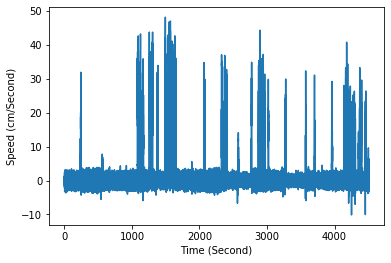

In [9]:
behav_sess = cache.get_behavior_session_data(846710859)

print("---- Metadata ----")
print("\n".join([f"{k}: {v}" for k, v in behav_sess.metadata.items()]))
print("------------------")

# Plot the running speed
plt.plot(behav_sess.running_speed.timestamps, behav_sess.running_speed.values)
_ = plt.xlabel('Time (Second)')
_ = plt.ylabel('Speed (cm/Second)')

### Memory management
Session objects cache certain values to enable faster access, such as time-consuming queries to the LIMS database.
In order to prevent issues with running out of memory when working with session objects in a loop, you should use the `cache_clear` method to clear the caches.

In [10]:
# Example of a cached query
# You can look at the cache of any call by invoking `cache_size` on a cached function
print("Current cache size:")
print(behav_sess.api.get_driver_line.cache_size())
# Clear the cache from the session object
behav_sess.cache_clear()
print("Cache size after clearing: ")
print(behav_sess.api.get_driver_line.cache_size())

Current cache size:
1
Cache size after clearing: 
0
